In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import List
import logging
from utils_ml import * 
from utils_word import *
import torch

### Method but with static embedding

In [2]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
filtered_concept_arr = np.unique(np.load("saved_files/overlapping_filtered_5_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

print("Concepts which were tracked",filtered_concept_arr.shape)
print("Abstracts",ngram_abstracts.shape)
print("Year associated to abstract",year_arr.shape)

word_co_occurrences = get_word_co_occurrences(filtered_concept_arr, ngram_abstracts, year_arr)

Concepts which were tracked (10235,)
Abstracts (66839,)
Year associated to abstract (66839,)


100%|██████████| 63633/63633 [00:03<00:00, 17822.21it/s]


### Get Embedding

In [3]:
c_inx_arr, c_encoding_arr = get_method_embeddings(filtered_concept_arr, year_arr, load = False, model_type="no_time_informed",save=False)

Loading models and vectors: 100%|██████████| 30/30 [00:04<00:00,  7.46it/s]


Found 212222 vectors, missed 94828 vectors.


Preparing encoding array: 100%|██████████| 10235/10235 [00:00<00:00, 19382.21it/s]


### Create Dataset

In [5]:
def create_dataset_indexing(data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1, print_test: bool = False, save=True):
    """
    Dataset indexing for time series data.

    Args:
        data (np.ndarray): The input data.
        word_co_occurrences (dict): Dictionary of word co-occurrences.
        year_arr (np.ndarray): Array of years.
        c_inx_arr (np.ndarray): Array of concept indices.
        input_window_size (int, optional): Size of the input window. Defaults to 5.
        output_window_size (int, optional): Size of the output window. Defaults to 3.
        offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        print_test (bool, optional): Whether to print test information. Defaults to False.

    Returns:
        np.ndarray: Positive index pair array.
        np.ndarray: Negative index pair array.
    """
    train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
    label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

    co_occur_concept_pair_arr = get_co_occur_concept_pair_after_year_arr(
        word_co_occurrences, label_year_range[0], label_year_range[-1])
    
    print(f"Training Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
    print(f"Label Window: {get_years_range(year_arr,-output_window_size-offset_to_current_year, -offset_to_current_year)}")



    # Precompute indices for each unique concept in c_inx_arr
    concept_to_indices = {concept: np.where(c_inx_arr == concept)[0] for concept in np.unique(c_inx_arr)}

    # Convert word_co_occurrences to a dictionary of sets for fast membership checking
    word_co_occurrences_set = {k: set(v) for k, v in word_co_occurrences.items()}

    pos_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr),2), dtype=int)
    
    for inx, pair in enumerate(co_occur_concept_pair_arr):
        pos_inx_pair_arr[inx, 0] = concept_to_indices[pair[0]][0]
        pos_inx_pair_arr[inx, 1] = concept_to_indices[pair[1]][0]

    print("Finished Positives")

    neg_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr), 2), dtype=int)
    checked_pairs = set()
    neg_inx = 0

    while neg_inx < len(pos_inx_pair_arr):
        sampled_pair = tuple(np.random.choice(train_window_data.shape[0], size=2, replace=False))
        
        # Ensure the sampled pair is not the same and hasn't been checked before
        if sampled_pair not in checked_pairs:
            checked_pairs.add(sampled_pair)
            concept_0, concept_1 = c_inx_arr[sampled_pair[0]], c_inx_arr[sampled_pair[1]]

            if concept_1 not in word_co_occurrences_set.get(concept_0, set()):
                neg_inx_pair_arr[neg_inx, 0] = concept_to_indices[concept_0][0]
                neg_inx_pair_arr[neg_inx, 1] = concept_to_indices[concept_1][0]
                neg_inx += 1
    print("Finished Negatives")

    if print_test:
        save_pos_arr = [word_co_occurrences[c_inx_arr[pos_inx_pair_arr[_][0]]][c_inx_arr[pos_inx_pair_arr[_][1]]] for _ in range(len(pos_inx_pair_arr))]
        save_neg_arr = [c_inx_arr[neg_inx_pair_arr[_][1]] in word_co_occurrences[c_inx_arr[neg_inx_pair_arr[_][0]]] for _ in range(len(neg_inx_pair_arr))]

        save_pos_arr = [x for xs in save_pos_arr for x in xs]
        
        print("Positive: Expect to be years: ", np.unique(save_pos_arr))
        print("Negative: Expect to be 0: ", np.sum(save_neg_arr))

    if save:
        np.save(f"saved_files/train_pos_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", pos_inx_pair_arr)
        np.save(f"saved_files/train_neg_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", neg_inx_pair_arr)

    return pos_inx_pair_arr, neg_inx_pair_arr


seq_length = 1
out_length = 3
batch_size = 128

print("Representation Vectors for tracked concepts",c_encoding_arr.shape)
print("Concept associted with representation", c_inx_arr.shape)
scaler = StandardScaler()
reshaped_data = c_encoding_arr.reshape(-1, c_encoding_arr.shape[-1])  
normalized_data = scaler.fit_transform(reshaped_data)
encoding_data = normalized_data.reshape(c_encoding_arr.shape)

load = False 
if not load:
    train_pos_inx_pair_arr_5_3_3, train_neg_inx_pair_arr_5_3_3 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3, print_test=True,save=False)

    train_pos_inx_pair_arr_5_3_0, train_neg_inx_pair_arr_5_3_0 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0, print_test=True,save=False)
    
else:
    train_pos_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_3.npy")
    train_neg_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_3.npy")

    train_pos_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_0.npy")
    train_neg_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_0.npy")


Representation Vectors for tracked concepts (10235, 30, 128)
Concept associted with representation (10235,)
Training Window: [2017]
Label Window: [2018 2019 2020]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2018 2019 2020]
Negative: Expect to be 0:  0
Training Window: [2020]
Label Window: [2021 2022 2023]
Finished Positives
Finished Negatives
Positive: Expect to be years:  [2021 2022 2023]
Negative: Expect to be 0:  0


In [6]:
class CustomPairDataset(Dataset):
    def __init__(self, train_window_data, pair_arr, labels, input_window_size, output_window_size, offset_to_current_year):
        self.train_window_data = train_window_data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
        self.pair_arr = pair_arr
        self.labels = labels
        self.shape = self.train_window_data.shape

    def __len__(self):
        return len(self.pair_arr)

    def __getitem__(self, idx):
        inx_0, inx_1 = self.pair_arr[idx]
        label = self.labels[idx]
        enc_0 = self.train_window_data[inx_0]
        enc_1 = self.train_window_data[inx_1]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        return torch.from_numpy(enc_01), torch.tensor([label], dtype=torch.float32), inx_0, inx_1 

def create_train_val_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year, test_size=0.2, random_state=42):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
    
    # Split indices into training and test sets
    train_idx, test_idx = train_test_split(
        np.arange(len(all_pairs)), test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Create training and test datasets
    train_dataset = CustomPairDataset(train_window_data, all_pairs[train_idx], all_labels[train_idx], input_window_size, output_window_size, offset_to_current_year)
    test_dataset = CustomPairDataset(train_window_data, all_pairs[test_idx], all_labels[test_idx], input_window_size, output_window_size, offset_to_current_year)
    
    return train_dataset, test_dataset

def create_test_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
     
    return CustomPairDataset(train_window_data, all_pairs, all_labels, input_window_size, output_window_size, offset_to_current_year)

train_dataset, val_dataset = create_train_val_datasets(
    train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_3, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_3, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 3, test_size=0.2)

test_dataset = create_test_datasets(
    train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_0, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_0, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 0)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
input_window_size = 1
output_window_size = 3
offset_to_current_year = 3

print(f"Training Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
print(f"Label Window: {get_years_range(year_arr,-output_window_size-offset_to_current_year, -offset_to_current_year)}")

offset_to_current_year = 0

print(f"Testing Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
print(f"Label Window: {get_years_range(year_arr,-output_window_size-offset_to_current_year, -offset_to_current_year)}")

Training Window: [2017]
Label Window: [2018 2019 2020]
Testing Window: [2020]
Label Window: [2021 2022 2023]


In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage
input_dim = train_dataset.train_window_data.shape[1] * train_dataset.train_window_data.shape[2] * 2  
model_mlp = MLP(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.005)
scheduler = CosineAnnealingLR(optimizer,T_max=10)

train_model(model_mlp, train_dataloader, val_dataloader, criterion, optimizer, scheduler, file_name='saved_ml_models/baseline_2_model.pth')

2024-10-31 08:57:25,922 - INFO - Epoch [1/50], Train Loss: 0.4770, Train Accuracy: 78.28%, Val Loss: 0.4521, Val Accuracy: 79.47%
2024-10-31 08:57:40,549 - INFO - Epoch [2/50], Train Loss: 0.4508, Train Accuracy: 79.66%, Val Loss: 0.4370, Val Accuracy: 80.22%
2024-10-31 08:57:54,000 - INFO - Epoch [3/50], Train Loss: 0.4394, Train Accuracy: 80.15%, Val Loss: 0.4324, Val Accuracy: 80.13%
2024-10-31 08:58:08,730 - INFO - Epoch [4/50], Train Loss: 0.4315, Train Accuracy: 80.51%, Val Loss: 0.4287, Val Accuracy: 80.39%
2024-10-31 08:58:24,815 - INFO - Epoch [5/50], Train Loss: 0.4233, Train Accuracy: 80.91%, Val Loss: 0.4246, Val Accuracy: 80.80%
2024-10-31 08:58:44,927 - INFO - Epoch [6/50], Train Loss: 0.4169, Train Accuracy: 81.20%, Val Loss: 0.4219, Val Accuracy: 80.75%
2024-10-31 08:59:02,787 - INFO - Epoch [7/50], Train Loss: 0.4109, Train Accuracy: 81.52%, Val Loss: 0.4205, Val Accuracy: 80.94%
2024-10-31 08:59:15,380 - INFO - Epoch [8/50], Train Loss: 0.4054, Train Accuracy: 81.87%,

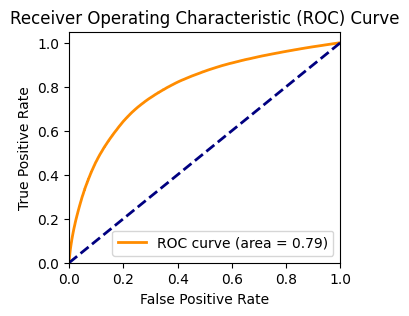

saved


0

In [9]:
model_mlp.load_state_dict(torch.load('saved_ml_models/baseline_2_model.pth'))
plot_roc(model_mlp, test_dataloader)
compute_roc(model_mlp, test_dataloader, filename="baseline_2")